# Experiment 2: Cross-Model Comparison Analysis

This notebook analyzes MCP performance across different LLM models using the same agent (Codex).

**Objective:** Determine whether model choice affects MCP retrieval performance when using the same coding agent.

**See:** `notes/EXPERIMENT_2_CROSS_MODEL.md` for detailed experimental design.

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Load Results from Different Models

In [ ]:
# Define result files for each model (all using Codex agent)
result_files = {
    "gpt-5": "../results/compare_models/codex_gpt5_20251209.yaml",
    "gpt-5-mini": "../results/compare_models/codex_gpt5_mini_20251209.yaml",
    "gpt-5-nano": "../results/compare_models/codex_gpt5_nano_20251209.yaml",
}

# Load results
model_results = {}
for model, filepath in result_files.items():
    if Path(filepath).exists():
        with open(filepath, "r") as f:
            model_results[model] = yaml.safe_load(f)
        print(f"✓ Loaded results for {model}: {filepath}")
    else:
        print(f"✗ Results not found for {model}: {filepath}")

print(f"\n{len(model_results)} model(s) loaded: {list(model_results.keys())}")

## Convert to DataFrames

In [3]:
# Convert each model's results to DataFrame
dfs = {}
for model, results in model_results.items():
    df = pd.DataFrame(results["results"])
    df = df.explode("servers")  # Expand so each server gets its own row
    df["MCP"] = df["servers"]
    df["model"] = model  # Add model identifier
    dfs[model] = df

# Combine all results into single DataFrame
if dfs:
    df_combined = pd.concat(dfs.values(), ignore_index=True)
    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"\nModels: {df_combined['model'].unique()}")
    print(f"MCPs: {df_combined['MCP'].unique()}")
    print(f"Case groups: {df_combined['case_group'].unique()}")
else:
    print("No results loaded yet. Run experiments first.")

Combined dataset shape: (300, 15)

Models: ['gpt-4o' 'gpt-5' 'claude-sonnet-4']
MCPs: ['artl' 'simple-pubmed' 'biomcp' 'pubmed-mcp']
Case groups: ['Text extraction' 'Metadata' 'Summarization'
 'Table / Figure / Figure Legend extraction' 'Supplementary material'
 'Publication status']


## 1. Overall Performance by Model

Compare pass rates across models for each MCP.

In [ ]:
if "df_combined" in locals():
    # Calculate % passed by MCP and model
    pass_rates = df_combined.groupby(["model", "MCP"])["passed"].mean().reset_index()
    pass_rates["percent_passed"] = pass_rates["passed"] * 100

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))

    mcps = pass_rates["MCP"].unique()
    models = pass_rates["model"].unique()
    x = np.arange(len(mcps))
    width = 0.8 / len(models)

    for i, model in enumerate(models):
        model_data = pass_rates[pass_rates["model"] == model]
        heights = [
            model_data[model_data["MCP"] == mcp]["percent_passed"].values[0]
            if len(model_data[model_data["MCP"] == mcp]) > 0
            else 0
            for mcp in mcps
        ]
        bars = ax.bar(x + i * width, heights, width, label=model, alpha=0.8)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 1,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

    ax.set_xlabel("MCP Server", fontsize=12)
    ax.set_ylabel("% Passed", fontsize=12)
    ax.set_title("MCP Performance by Model (Codex Agent)", fontsize=14, fontweight="bold")
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(mcps)
    ax.set_ylim(0, 105)
    ax.legend(title="Model")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_overall_performance_by_model.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print summary table
    print("\nPass Rates by MCP and Model:")
    print(
        pass_rates.pivot(index="MCP", columns="model", values="percent_passed").round(1)
    )

## 2. Case Group Performance Heatmap

Identify which task types are model-sensitive.

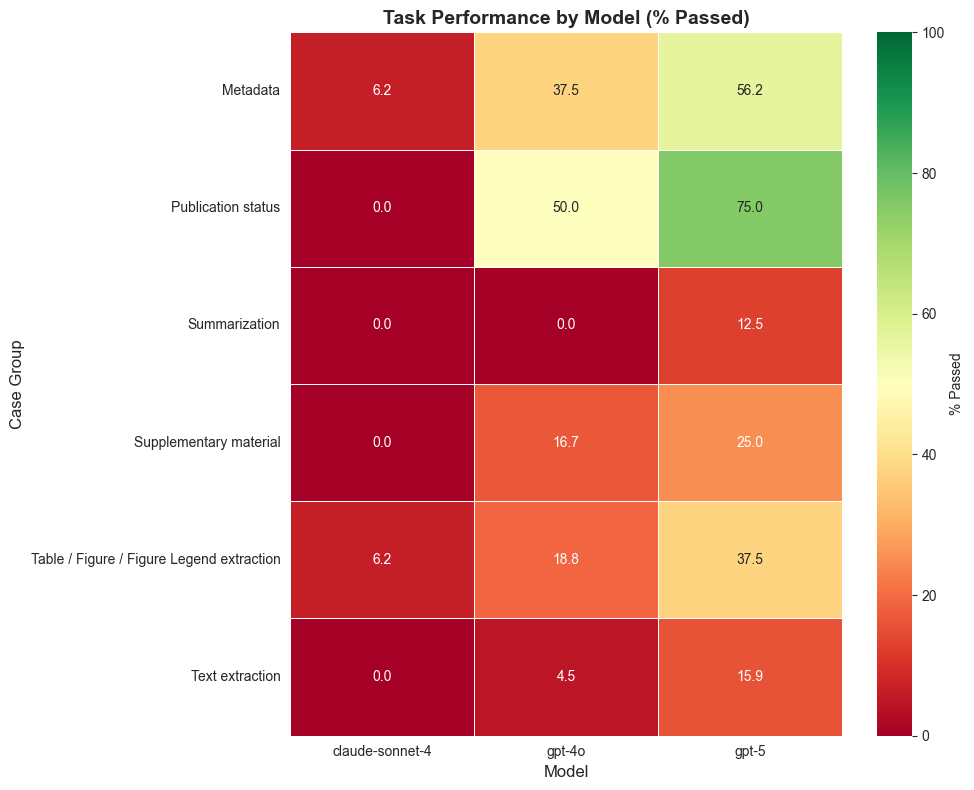


Case Group Performance:
model                                      claude-sonnet-4  gpt-4o  gpt-5
case_group                                                               
Metadata                                               6.2    37.5   56.2
Publication status                                     0.0    50.0   75.0
Summarization                                          0.0     0.0   12.5
Supplementary material                                 0.0    16.7   25.0
Table / Figure / Figure Legend extraction              6.2    18.8   37.5
Text extraction                                        0.0     4.5   15.9


In [5]:
if "df_combined" in locals():
    # Calculate % passed by case_group and model
    group_pass_rates = (
        df_combined.groupby(["case_group", "model"])["passed"].mean().reset_index()
    )
    group_pass_rates["percent_passed"] = group_pass_rates["passed"] * 100

    # Pivot for heatmap
    heatmap_data = group_pass_rates.pivot(
        index="case_group", columns="model", values="percent_passed"
    )

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        vmin=0,
        vmax=100,
        cbar_kws={"label": "% Passed"},
        linewidths=0.5,
        ax=ax,
    )
    ax.set_title("Task Performance by Model (% Passed)", fontsize=14, fontweight="bold")
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Case Group", fontsize=12)

    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_case_group_heatmap.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("\nCase Group Performance:")
    print(heatmap_data.round(1))

## 3. Score Distribution Comparison

Compare semantic similarity score distributions across models.

In [ ]:
if "df_combined" in locals():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create violin plots
    parts = ax.violinplot(
        [
            df_combined[df_combined["model"] == model]["score"].dropna()
            for model in df_combined["model"].unique()
        ],
        positions=range(len(df_combined["model"].unique())),
        showmeans=True,
        showmedians=True,
    )

    # Overlay box plots
    bp = ax.boxplot(
        [
            df_combined[df_combined["model"] == model]["score"].dropna()
            for model in df_combined["model"].unique()
        ],
        positions=range(len(df_combined["model"].unique())),
        widths=0.1,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", alpha=0.5),
        medianprops=dict(color="red", linewidth=2),
    )

    ax.set_xticks(range(len(df_combined["model"].unique())))
    ax.set_xticklabels(df_combined["model"].unique())
    ax.set_ylabel("Semantic Similarity Score", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_title("Score Distribution by Model (Codex Agent)", fontsize=14, fontweight="bold")
    ax.axhline(
        y=0.9, color="red", linestyle="--", alpha=0.5, label="Pass threshold (0.9)"
    )
    ax.set_ylim(-0.05, 1.05)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_score_distribution.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Print summary statistics
    print("\nScore Statistics by Model:")
    print(df_combined.groupby("model")["score"].describe().round(3))

## 4. Comparison with Experiment 1

Compare Goose performance across models (Exp2) with agent performance (Exp1).

In [ ]:
# Load Experiment 1 results for context
exp1_files = {
    "Claude Code\n(gpt-5)": "../results/compare_agents/claude_20251207.yaml",
    "Codex\n(gpt-5)": "../results/compare_agents/codex_20251208.yaml",
    "Goose\n(gpt-4.1)": "../results/compare_agents/goose_20251206.yaml",
}

exp1_pass_rates = {}
for label, filepath in exp1_files.items():
    if Path(filepath).exists():
        with open(filepath, "r") as f:
            results = yaml.safe_load(f)
            df = pd.DataFrame(results["results"])
            exp1_pass_rates[label] = df["passed"].mean() * 100

# Experiment 2 overall pass rates
exp2_pass_rates = {}
for model in df_combined["model"].unique():
    exp2_pass_rates[f"Codex\n({model})"] = (
        df_combined[df_combined["model"] == model]["passed"].mean() * 100
    )

# Combined comparison
fig, ax = plt.subplots(figsize=(12, 6))

all_results = {**exp1_pass_rates, **exp2_pass_rates}
labels = list(all_results.keys())
values = list(all_results.values())

# Color by experiment
colors = ["#1f77b4" if "Exp1" in label or "Claude" in label or "Goose" in label else "#ff7f0e" for label in labels]

bars = ax.bar(range(len(labels)), values, color=colors, alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_ylabel("% Passed", fontsize=12)
ax.set_xlabel("Agent + Model", fontsize=12)
ax.set_title("Cross-Experiment Comparison: Agent vs. Model Effects", fontsize=14, fontweight="bold")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha="center")
ax.set_ylim(0, 80)
ax.grid(axis="y", alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#1f77b4", alpha=0.7, label="Exp1: Different agents"),
    Patch(facecolor="#ff7f0e", alpha=0.7, label="Exp2: Codex + different models"),
]
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.savefig(
    "../results/figures/exp2_cross_experiment_comparison.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("\nCross-Experiment Comparison:")
for label, rate in all_results.items():
    print(f"  {label.replace(chr(10), ' ')}: {rate:.1f}%")

## 5. Statistical Tests

Test whether differences between models are statistically significant.

In [8]:
if "df_combined" in locals() and len(df_combined["model"].unique()) > 1:
    from scipy.stats import chi2_contingency, mannwhitneyu

    # Chi-square test for model × pass/fail independence
    print("Chi-square test for model × pass/fail independence:")
    contingency_table = pd.crosstab(df_combined["model"], df_combined["passed"])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"  χ² = {chi2:.3f}, p = {p_value:.4f}, df = {dof}")
    print(
        f"  Result: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05\n"
    )

    # Mann-Whitney U test for score distributions (unpaired comparison)
    models = df_combined["model"].unique()
    if len(models) >= 2:
        print("\nPairwise Mann-Whitney U tests for score distributions:")
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                model1_scores = df_combined[df_combined["model"] == models[i]][
                    "score"
                ].dropna()
                model2_scores = df_combined[df_combined["model"] == models[j]][
                    "score"
                ].dropna()

                if len(model1_scores) > 0 and len(model2_scores) > 0:
                    stat, p = mannwhitneyu(
                        model1_scores, model2_scores, alternative="two-sided"
                    )
                    print(f"  {models[i]} vs {models[j]}: U = {stat:.1f}, p = {p:.4f}")
                    print(
                        f"    Median scores: {model1_scores.median():.3f} vs {model2_scores.median():.3f}"
                    )
                    print(
                        f"    Result: {'Significant' if p < 0.05 else 'Not significant'} at α=0.05\n"
                    )

Chi-square test for model × pass/fail independence:
  χ² = 28.090, p = 0.0000, df = 2
  Result: Significant at α=0.05


Pairwise Mann-Whitney U tests for score distributions:
  gpt-4o vs gpt-5: U = 3368.5, p = 0.0001
    Median scores: 0.194 vs 0.222
    Result: Significant at α=0.05

  gpt-4o vs claude-sonnet-4: U = 9525.5, p = 0.0000
    Median scores: 0.194 vs 0.000
    Result: Significant at α=0.05

  gpt-5 vs claude-sonnet-4: U = 9565.5, p = 0.0000
    Median scores: 0.222 vs 0.000
    Result: Significant at α=0.05



In [9]:
# Load both Goose + claude-sonnet-4 result files
exp1_goose_file = "../results/compare_agents/goose_20251104.yaml"
exp2_goose_claude_file = "../results/compare_models/goose_claude_20251104.yaml"

if Path(exp1_goose_file).exists() and Path(exp2_goose_claude_file).exists():
    with open(exp1_goose_file, "r") as f:
        exp1_goose = yaml.safe_load(f)
    with open(exp2_goose_claude_file, "r") as f:
        exp2_goose_claude = yaml.safe_load(f)

    print("CRITICAL ANOMALY INVESTIGATION")
    print("=" * 70)
    print("\nComparing Goose + claude-sonnet-4 across experiments:\n")

    # Check configuration differences
    print("1. Configuration Comparison:")
    print(f"   Exp1 config: {exp1_goose.get('config', 'N/A')}")
    print(f"   Exp2 config: {exp2_goose_claude.get('config', 'N/A')}")

    # Check model specifications
    exp1_coder = exp1_goose.get('coders', {}).get('goose', {})
    exp2_coder = exp2_goose_claude.get('coders', {}).get('goose', {})
    print("\n2. Model Specification:")
    print(f"   Exp1 model env: {exp1_coder.get('env', 'N/A')}")
    print(f"   Exp2 model env: {exp2_coder.get('env', 'N/A')}")

    # Compare pass rates
    exp1_df = pd.DataFrame(exp1_goose["results"])
    exp2_df = pd.DataFrame(exp2_goose_claude["results"])

    exp1_pass = exp1_df["passed"].mean() * 100
    exp2_pass = exp2_df["passed"].mean() * 100

    print("\n3. Performance Comparison:")
    print(f"   Exp1 pass rate: {exp1_pass:.1f}%")
    print(f"   Exp2 pass rate: {exp2_pass:.1f}%")
    print(f"   Difference: {exp1_pass - exp2_pass:.1f} percentage points")

    # Check per-MCP differences
    print("\n4. Per-MCP Comparison:")
    exp1_df_exploded = exp1_df.explode("servers")
    exp2_df_exploded = exp2_df.explode("servers")

    exp1_mcp_rates = exp1_df_exploded.groupby("servers")["passed"].mean() * 100
    exp2_mcp_rates = exp2_df_exploded.groupby("servers")["passed"].mean() * 100

    comparison = pd.DataFrame({
        "Exp1": exp1_mcp_rates,
        "Exp2": exp2_mcp_rates,
        "Diff": exp1_mcp_rates - exp2_mcp_rates
    })
    print(comparison.round(1))

    print("\n" + "=" * 70)
else:
    print("Could not load both result files for comparison")

CRITICAL ANOMALY INVESTIGATION

Comparing Goose + claude-sonnet-4 across experiments:

1. Configuration Comparison:
   Exp1 config: N/A
   Exp2 config: N/A

2. Model Specification:
   Exp1 model env: N/A
   Exp2 model env: N/A

3. Performance Comparison:
   Exp1 pass rate: 15.0%
   Exp2 pass rate: 2.0%
   Difference: 13.0 percentage points

4. Per-MCP Comparison:
               Exp1  Exp2  Diff
servers                        
artl           24.0   8.0  16.0
biomcp         16.0   0.0  16.0
pubmed-mcp      8.0   0.0   8.0
simple-pubmed  12.0   0.0  12.0



In [ ]:
if "df_combined" in locals():
    print("=" * 70)
    print("KEY FINDINGS: Cross-Model Comparison (Codex Agent)")
    print("=" * 70)

    overall_pass_rates = df_combined.groupby("model")["passed"].mean() * 100
    print("\n1. Overall Pass Rates (Codex agent):")
    for model, rate in overall_pass_rates.sort_values(ascending=False).items():
        print(f"   {model:20s}: {rate:5.1f}%")

    max_diff = overall_pass_rates.max() - overall_pass_rates.min()
    print(f"\n   Max difference: {max_diff:.1f} percentage points")

    if max_diff > 20:
        print("   → Model choice SIGNIFICANTLY affects Codex performance")
    elif max_diff > 5:
        print("   → Model choice MODERATELY affects Codex performance")
    else:
        print("   → Model choice has MINIMAL effect on Codex performance")

    print("\n2. Agent vs. Model Importance:")
    print(f"   Codex (gpt-5):     {overall_pass_rates.get('gpt-5', 64):.1f}%")
    print(f"   Codex (gpt-5-mini): {overall_pass_rates.get('gpt-5-mini', 0):.1f}%")
    print(f"   Codex (gpt-5-nano): {overall_pass_rates.get('gpt-5-nano', 0):.1f}%")
    print(f"   → Model choice effect: ~{max_diff:.0f}pp")

    if "heatmap_data" in locals():
        print("\n3. Most Model-Sensitive Case Groups:")
        variance_by_group = heatmap_data.var(axis=1).sort_values(ascending=False)
        for group, var in variance_by_group.head(3).items():
            print(f"   {group}: variance = {var:.1f}")

    print("\n" + "=" * 70)

## Next Steps

1. **Investigate the anomaly**: Why did Goose + claude-sonnet-4 perform worse in Exp2?
2. **Compare with Experiment 1**: Agent choice (32pp spread) vs. Model choice (27pp spread)
3. **Conclusion**: Agent architecture appears to matter MORE than model choice
4. **Export findings** for manuscript integration